GOAL: Using User Reviews to classify user status 

Algorithms: 
    - Multinomial NB
    -Naive Bayes
    



In [110]:
%pylab inline
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from collections import Counter
from collections import defaultdict
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from confusion_mat import show_confusion_matrix,plot_roc
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer


# Evaluation - Optimization Tools
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, classification_report,confusion_matrix
from sklearn.preprocessing import normalize, scale, StandardScaler, Normalizer
from sklearn.grid_search import GridSearchCV

# Classification Algorithms
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier


Populating the interactive namespace from numpy and matplotlib


ImportError: cannot import name 'plot_roc'

In [3]:
user = pd.read_pickle('data/user')
review = pd.read_pickle('data/review')
# business =pd.read_pickle('data/business')

In [4]:
review.head(5)

,user_id,review_id,text,votes_cool,business_id,votes_funny,stars,date,votes_useful
0,4EjpgvHpcCMETNlSq8WAZg,6QRY_qLXov_ChIVtlxH-ow,husband went labor day monday night eat crab l...,0,bfANvTlrA7cpgiRoYjAc0g,0,4,2015-09-12,1
1,SFnhFNUocpo886s6kl71mA,nJRltLIH_0GqR9u-Ea7HPw,went tuesday night throw back drink price pret...,0,gl4T1-8baLVWGVvBkka3WQ,0,4,2011-08-10,1
2,3S6jzL8bfOxUKGIN4G24lA,W9L0VNIMx9eSFlZhctpDAg,ive twice first time wanted try pizza oven bro...,0,QnAzW6KMSciUcuJ20oI3Bw,0,2,2016-04-23,0
3,LpM9Xnz97en0KwDPJQu_gQ,J8sgYXnoMi-klX-tXxqz1w,place great unique menu item staple service ex...,0,Hww3i4P9WsVLsTyXrCG89w,0,5,2014-12-04,0
4,W1g-bmBSwk7IVqH7QaYDrg,7uwdXVqGtnHS871lsbRpgA,usually love place came wednesday family 6 tol...,0,W4JGv_yo3vuhsa-AJnXnww,0,2,2016-06-01,0


In [5]:
len(review)

32614

In [6]:
elite_userid = user['user_id'].ix[user['elite_status'] == 1]

In [7]:
review['elite_status'] = np.where(review['user_id'].isin(elite_userid), 1, 0)

In [8]:
X = review['text']
y = review['elite_status']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [9]:
vectorizer = TfidfVectorizer()
vect_X_train = vectorizer.fit_transform(X_train)
vect_X_test = vectorizer.transform(X_test)

In [72]:
!pip install gensim

    100% |████████████████████████████████| 4.3MB 162kB/s 
  Running setup.py bdist_wheel for smart-open ... - \ | done
  Stored in directory: /Users/Charlotte/Library/Caches/pip/wheels/a6/61/e5/74ff1f24ad225557675acc0cc2ccb196d7b83c1eb7d80390c8
  Running setup.py bdist_wheel for bz2file ... - \ done
  Stored in directory: /Users/Charlotte/Library/Caches/pip/wheels/31/9c/20/996d65ca104cbca940b1b053299b68459391c01c774d073126
Successfully built smart-open bz2file


In [73]:
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec

/Users/Charlotte/anaconda/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [80]:
tokens = word_tokenize(review.text[0])

In [88]:
model = Doc2Vec(min_count=1)
model.build_vocab(review.text[:2])

AttributeError: 'str' object has no attribute 'words'

In [84]:
model?


In [83]:
model.infer_vector(tokens,alpha=0.1, min_alpha=0.0001, steps=5)

AttributeError: 'Doc2Vec' object has no attribute 'syn0'

In [10]:
def cross_val(model,X_train,y_train):
   
    model.fit(X_train,y_train)

    print(str(model).split('(')[0],'CV:')
    print('-- Accuracy:', round((cross_val_score(model, X_train, y_train, cv=3,scoring='accuracy').mean()), 3),
          '| Recall:', round(cross_val_score(model, X_train, y_train, cv=3, scoring='recall').mean(), 3),
          '| Precision:', round(cross_val_score(model, X_train, y_train, cv=3, scoring='precision').mean(), 3),
          '| f1:', round(cross_val_score(model, X_train, y_train, cv=3, scoring='f1').mean(), 3),
         '| auc:',round(cross_val_score(model, X_train, y_train, cv=3, scoring= 'roc_auc').mean(), 3))
            

In [11]:
mnb = MultinomialNB()
rf = RandomForestClassifier()
svc = SVC() # takes forever to run 
ada = AdaBoostClassifier()  
logit = LogisticRegression()
gbc = GradientBoostingClassifier() # takes forever to run 

In [11]:
cross_val(rf,vect_X_train, y_train)

RandomForestClassifier CV:
-- Accuracy: 0.775 | Recall: 0.049 | Precision: 0.503 | f1: 0.098 | auc: 0.661


In [12]:
cross_val(ada,vect_X_train, y_train) 

AdaBoostClassifier CV:
-- Accuracy: 0.78 | Recall: 0.232 | Precision: 0.544 | f1: 0.325 | auc: 0.734


In [12]:
cross_val(mnb,vect_X_train, y_train)

MultinomialNB CV:
-- Accuracy: 0.774 | Recall: 0.013 | Precision: 0.484 | f1: 0.025 | auc: 0.508


In [13]:
cross_val(logit,vect_X_train, y_train)

LogisticRegression CV:
-- Accuracy: 0.792 | Recall: 0.193 | Precision: 0.627 | f1: 0.295 | auc: 0.77


### LogisticRegression and AdaBoostClassfier are selected to the next round due to their the highest score in accuracy and f1

# Hyperparameters Tuning

In [14]:
def gs_abc(X_train,y_train):
    param = [{'learning_rate': [0.5,0.8,1],'n_estimators': [30,50]}]
    grid_search = GridSearchCV(AdaBoostClassifier(), param_grid = param, verbose = 1, cv = 3,n_jobs= -1, scoring = 'accuracy')
    grid_search.fit(X_train, y_train)
    param = grid_search.best_params_
    return param


In [16]:
gs_abc(vect_X_train, y_train) 

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  4.2min finished


{'learning_rate': 0.5, 'n_estimators': 50}

In [19]:
#since learning rate and n_estimators are at the border , I want to run another GS 

In [17]:
def gs_abc(X_train,y_train):
    param = [{'learning_rate': [0.3,0.5],'n_estimators': [50,100]}]
    grid_search = GridSearchCV(AdaBoostClassifier(), param_grid = param, verbose = 1, cv = 3,n_jobs= -1, scoring = 'accuracy')
    grid_search.fit(X_train, y_train)
    param = grid_search.best_params_
    return param


In [18]:
gs_abc(vect_X_train, y_train) 

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  5.2min finished


{'learning_rate': 0.5, 'n_estimators': 100}

In [24]:
def gs_logit(X_train,y_train):
    param_grid = [{'C': [0.1, 1, 10] }]
    grid_search = GridSearchCV(LogisticRegression(penalty='l2'), param_grid, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    param = grid_search.best_params_
    return param


In [25]:
gs_logit(vect_X_train, y_train) 

{'C': 1}

In [29]:
def gs_logit(X_train,y_train):
    param_grid = [{'C': [ 1, 3,5] ,'penalty': ['l1','l2']}]
    grid_search = GridSearchCV(LogisticRegression(penalty='l2'), param_grid, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    param = grid_search.best_params_
    return param


In [30]:
gs_logit(vect_X_train, y_train) 

{'C': 1, 'penalty': 'l2'}

In [46]:
def fit_model(model,X_train,y_train,X_test,y_test):
    "Fit Model --- Return Evaluation Metrics"
    
    model = model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    print(str(model).split('(')[0],':')
    print('Train | Accuracy:', round(accuracy_score(y_train, train_pred),3),
          '| Recall',round(recall_score(y_train, train_pred),3),
          '| Precision',round(precision_score(y_train, train_pred),3),
          '| f1',round(f1_score(y_train, train_pred),3))

    print('Test | Accuracy:', round(accuracy_score(y_test, test_pred),3),
          '| Recall',round(recall_score(y_test, test_pred),3),
          '| Precision',round(precision_score(y_test, test_pred),3),
          '| f1',round(f1_score(y_test, test_pred),3))
    return test_pred
    

In [47]:
logit_tuned = LogisticRegression(C = 1, penalty = 'l2')

In [32]:
ada_tuned = AdaBoostClassifier(learning_rate = 0.5, n_estimators = 500)

In [49]:
logit_test_pred = fit_model(logit_tuned, vect_X_train, y_train,vect_X_test, y_test)

LogisticRegression :
Train | Accuracy: 0.831 | Recall 0.327 | Precision 0.812 | f1 0.466
Test | Accuracy: 0.79 | Recall 0.255 | Precision 0.619 | f1 0.362


In [36]:
fit_model(ada_tuned, vect_X_train, y_train,vect_X_test, y_test)

AdaBoostClassifier :
Train | Accuracy: 0.824 | Recall 0.37 | Precision 0.711 | f1 0.486
Test | Accuracy: 0.78 | Recall 0.269 | Precision 0.56 | f1 0.364


In [13]:
fit_model(logit, vect_X_train, y_train,vect_X_test, y_test)

LogisticRegression :
Train | Accuracy: 0.804 | Recall 0.406 | Precision 0.699 | f1 0.513
Test | Accuracy: 0.787 | Recall 0.381 | Precision 0.631 | f1 0.475


In [12]:
fit_model(ada, vect_X_train, y_train,vect_X_test, y_test)

AdaBoostClassifier :
Train | Accuracy: 0.765 | Recall 0.278 | Precision 0.578 | f1 0.376
Test | Accuracy: 0.764 | Recall 0.271 | Precision 0.57 | f1 0.368


In [68]:
a = confusion_matrix(y_test, logit_test_pred )

In [65]:
print(classification_report(y_test, logit_test_pred ))

             precision    recall  f1-score   support

          0       0.81      0.95      0.87      5000
          1       0.62      0.26      0.36      1523

avg / total       0.76      0.79      0.75      6523



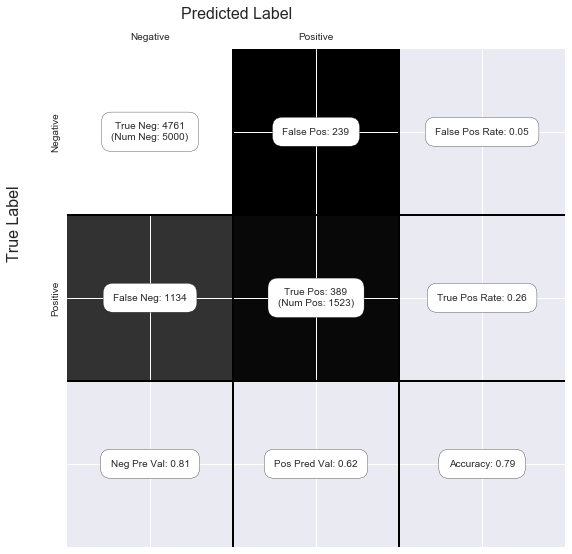

In [69]:
show_confusion_matrix(a,
                     class_labels=["Negative", "Positive"])

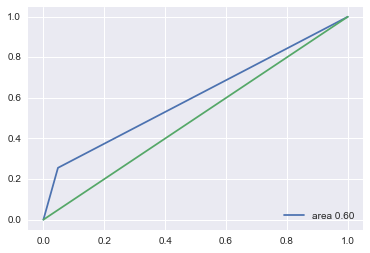

In [108]:
plot_roc(y_test, logit_test_pred )